# Wrangling Scoary Output: Are there hypothetical proteins associated resistance?

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from glob import glob
import os
from adjustText import adjust_text
mpl.style.use('seaborn-white')

#### INPUT #####
annotation_df = '/nas2/users/hermuba/parsed_anno/ecoli.gold_anno_df'
scoary_result = '/nas2/users/hermuba/scoary'

#### OUTPUT #####
fig_path = '/nas2/users/hermuba/fig'


# read annotation file
gold_anno = pd.read_pickle(annotation_df)
hypo = gold_anno.loc[gold_anno['hypo_nr']==True, 'cluster']
card = gold_anno.loc[gold_anno['ARO'].notnull(), 'cluster']

# list of antibiotics
abx_list = [x.split('/')[-1].split('_')[0] for x in glob(scoary_result+'/*.results.csv')]

def read_scoary(abx):
    fname = os.path.join(scoary_result,'{}_08_02_2021_1335.results.csv').format(abx)
    df = pd.read_csv(fname, header = 0, index_col = 0)
    return df
def filter_scoary(df):
    
    return df.loc[(df['Benjamini_H_p']<0.05)& (df['Odds_ratio']>8)]

def Volcano(abx):
    f,ax = plt.subplots()

    scoary = read_scoary(abx)
    second_largest = df.loc[df['Odds_ratio']!=np.inf, 'Odds_ratio'].max()*1.5
    second_smallest = df.loc[df['Odds_ratio']!=-np.inf, 'Odds_ratio'].min()
    scoary.replace(np.inf, second_largest).replace(-np.inf,second_smallest)
    
    scoary['log2 Odds ratio'] = np.log2(scoary['Odds_ratio'])
    scoary['-log10 P-value'] = -np.log(scoary['Benjamini_H_p'])
    scoary.plot(kind = 'scatter', x = 'log2 Odds ratio', y = '-log10 P-value', color = 'grey', ax = ax)

    # label card genes
    scoary.loc[scoary.index.isin(hypo)].plot(kind = 'scatter', x = 'log2 Odds ratio', y = '-log10 P-value', color = 'salmon', ax = ax, label = 'Hypothetical Proteins')
    
    card_sco = scoary.loc[scoary.index.isin(card)]
    card_sco.plot(kind = 'scatter', x = 'log2 Odds ratio', y = '-log10 P-value', color = 'turquoise', ax = ax, label = 'CARD')
    
    to_lbl = card_sco.loc[card_sco['-log10 P-value']>2]
    texts = []
    for index,row in to_lbl.iterrows():
        
        aro_name = gold_anno.loc[gold_anno['cluster']==index, 'Best_Hit_ARO']
        
        texts.append(ax.text(x = row['log2 Odds ratio'], y = row['-log10 P-value'], s = aro_name.values[0]))
    
    # adjust text position
    adjust_text(texts)
    ax.set_title('{} Resistant Associated Genes'.format(abx.capitalize()))
    plt.legend()
    f.savefig(os.path.join(fig_path,'{}.svg'.format(abx)), format = 'svg', dpi = 300, )

In [2]:
gold_anno['hypo_nr'].sum()/gold_anno.shape[0]

0.4886540254895866

In [3]:
gold_anno['hypo_nr'].sum()

20436

In [4]:
def extract_anno(df):
    ''' return percentage to GO annotations'''
    clus_name = df.index.tolist()
    anno_subset = gold_anno.loc[gold_anno['cluster'].isin(clus_name)]
    
    return anno_subset
def anno_stat(anno_subset):
    go_perc = anno_subset['GO'].count()/anno_subset.shape[0]
    hypo_perc = anno_subset['hypo_nr'].count()/anno_subset.shape[0]
    card_perc = anno_subset['is_card'].sum()/anno_subset.shape[0]
    resfam_perc = anno_subset['resfam'].count()/anno_subset.shape[0]
    
    return [go_perc, hypo_perc, card_perc, resfam_perc, anno_subset.shape[0]]
def extract_go_term(series):
    ''' extract all go term'''
    # remove nan
    series.dropna(inplace = True)
    
    all_go_terms = set()
    for sid in series.index:
        go = series[sid]
        #go = go.split(',')
        #go = [g.replace('{','').replace('}','').replace('\'','').replace('\"','') for g in go]
        #series[sid] = go
        all_go_terms = all_go_terms.union(go)
        #print(all_go_terms)
    # make into table
    df = pd.DataFrame(index = series.index, columns = all_go_terms)
    for sid in series.index:
        df.loc[sid, list(series[sid])] = True
    df.fillna(False, inplace =True)
    
    return df

In [5]:
all_stats = []
for abx in abx_list:
    df = read_scoary(abx)
    resist_stats = anno_stat(extract_anno(filter_scoary(df)))
    all_stats.append([abx]+resist_stats)
    
all_stats = pd.DataFrame(all_stats, columns = ['Antibiotics', '%GO', '%Hypothetical', '%CARD', '%Resfam', 'Number of genes'])

/home/hermuba/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in long_scalars
  
/home/hermuba/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in long_scalars
  if __name__ == '__main__':
/home/hermuba/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in long_scalars
  # Remove the CWD from sys.path while we load stuff.
/home/hermuba/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in long_scalars
  # This is added back by InteractiveShellApp.init_path()


In [30]:
all_stats

,Antibiotics,%GO,%Hypothetical,%CARD,%Resfam,Number of genes,Susceptible,Resistant
0,cefepime,NaN,NaN,NaN,NaN,0,32.0,20.0
13,tigecycline,NaN,NaN,NaN,NaN,0,1033.0,1.0
16,cephalothin,NaN,NaN,NaN,NaN,0,2.0,86.0
3,tobramycin,1.000000,0.000000,1.000000,1.000000,1,24.0,67.0
19,trimethoprim-sulfamethoxazole,1.000000,0.000000,0.500000,0.500000,2,20.0,53.0
17,imipenem,0.500000,0.500000,0.500000,0.500000,2,1100.0,8.0
20,amoxicillin-clavulanate,1.000000,0.000000,0.600000,0.600000,5,57.0,51.0
8,trimethoprim,0.888889,0.000000,0.333333,0.333333,9,25.0,58.0
21,azithromycin,0.636364,0.181818,0.181818,0.363636,11,156.0,14.0
10,ceftriaxone,0.687500,0.125000,0.250000,0.250000,16,22.0,48.0


In [6]:
# add phenotype count
import pandas as pd
pivot = pd.read_csv('/home/hermuba/nas2/amr/ecoli_amr_pivot.csv', dtype = {'genome_id': str})
pivot.set_index('genome_id', inplace = True)
pivot = pivot.replace(1, 'Resistant').replace(0, 'Susceptible')

count_df = pd.DataFrame(index = pivot.columns, columns = ['Susceptible', 'Resistant'])
for col in pivot.columns:
    count = pivot[col].value_counts()
    count_df.loc[col] = count
count_df.fillna(0, inplace = True)


In [7]:
all_stats = all_stats.merge(count_df, left_on = 'Antibiotics', right_index = True).sort_values('Number of genes')

In [31]:
all_stats.to_csv('~/nas2/fig/abx_data_abundance.csv')

# Run GO enrichment

In [12]:
onto_root = '/home/hermuba/data0118/ontologies/'
from goatools.obo_parser import GODag
obodag = GODag(onto_root + "go-basic.obo")

from goatools.associations import read_associations
ns2assoc = read_associations('/home/hermuba/data0118/ontologies/ec_40000.id2go', anno_type='id2gos', namespace = 'BP', no_top=True)

/home/hermuba/data0118/ontologies/go-basic.obo: fmt(1.2) rel(2019-07-01) 47,413 GO Terms
HMS:0:00:00.559953  33,893 annotations READ: /home/hermuba/data0118/ontologies/ec_40000.id2go 
**ERROR IdToGosReader(..., godag=None).get_id2gos: GODAG is None. IGNORING namespace(BP)

13373 IDs in all associations

In [32]:
# run for all 

from goatools.go_enrichment import GOEnrichmentStudy 
from goatools.godag_plot import plot_gos, plot_results, plot_goid2goobj

# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter(os.path.join(fig_path,'go_enrich.xlsx'), engine='xlsxwriter')

def run_GO_enrich(gene_ids, name, fig_path = fig_path, gold_anno = gold_anno, writer = writer):
    ''' given resistance gene ids, compare to background (whole pan-genome), run GENE ontology enrichment'''
    
    # start new study object
    goea = GOEnrichmentStudy(gold_anno.index.tolist(), ns2assoc, obodag, propagate_counts = False,
        alpha = 0.05, # default significance cut-off
        methods = ['fdr_bh'])
    
    # run
    results_nt = goea.run_study(gene_ids)
    
    # filter to significant 
    goea_results_sig = [r for r in results_nt if r.p_fdr_bh < 0.05]
    
    # plot it
    #if len(goea_results_sig)>0:
    #    plot_results(os.path.join(fig_path,"{}_{NS}.png".format(name)), goea_results_sig)
    
    # write text to file
    go_id = [g.GO for g in goea_results_sig]
    goresult_df = pd.DataFrame([[obodag[gid].name, obodag[gid].namespace, gid] for gid in go_id], columns = ['Name', 'Namespace', 'ID'])
    goresult_df.to_excel(writer, sheet_name = name)
    


Load GOEA Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
 32% 13,373 of 41,821 population items found in association

Run GOEA Gene Ontology Analysis: current study set of 21 IDs ... 33%      7 of     21 study items found in association
100%     21 of     21 study items found in population(41821)
Calculating 2,191 uncorrected p-values using fisher_scipy_stats
   2,191 GO terms are associated with 13,373 of 41,821 population items
      14 GO terms are associated with      7 of     21 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)


/home/hermuba/miniconda3/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
posx and posy should be finite values
posx and posy should be finite values
/home/hermuba/miniconda3/lib/python3.6/site-packages/matplotlib/transforms.py:361: RuntimeWarning: invalid value encountered in double_scalars
  return points[1, 0] - points[0, 0]
/home/hermuba/miniconda3/lib/python3.6/site-packages/adjustText/__init__.py:31: RuntimeWarning: invalid value encountered in less
  x_in = np.logical_and(x>x1, x<x2)
/home/hermuba/miniconda3/lib/python3.6/site-packages/adjustText/__init__.py:31: RuntimeWarning: invalid value encountered in greater
  x_in = np.logical_and(x>x1, x<x2)
/home/hermuba/miniconda3/lib/python3.6/site-packages/adjustText/__init__.py:32: RuntimeWarning: invalid value encountered in less
  y_in = np.logical_and(y>y1, y<y2)
/home/hermuba/miniconda3/lib/python3.6/site-packages/adjust


Load GOEA Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
 32% 13,373 of 41,821 population items found in association

Run GOEA Gene Ontology Analysis: current study set of 43 IDs ... 40%     17 of     43 study items found in association
100%     43 of     43 study items found in population(41821)
Calculating 2,191 uncorrected p-values using fisher_scipy_stats
   2,191 GO terms are associated with 13,373 of 41,821 population items
      21 GO terms are associated with     17 of     43 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Load GOEA Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
 32% 13,373 of 41,821 population items found in association

Run GOEA Gene Ontology An

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values



Load GOEA Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
 32% 13,373 of 41,821 population items found in association

Run GOEA Gene Ontology Analysis: current study set of 52 IDs ... 31%     16 of     52 study items found in association
100%     52 of     52 study items found in population(41821)
Calculating 2,191 uncorrected p-values using fisher_scipy_stats
   2,191 GO terms are associated with 13,373 of 41,821 population items
      27 GO terms are associated with     16 of     52 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)


posx and posy should be finite values
posx and posy should be finite values



Load GOEA Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
 32% 13,373 of 41,821 population items found in association

Run GOEA Gene Ontology Analysis: current study set of 909 IDs ... 31%    286 of    909 study items found in association
100%    909 of    909 study items found in population(41821)
Calculating 2,191 uncorrected p-values using fisher_scipy_stats
   2,191 GO terms are associated with 13,373 of 41,821 population items
     198 GO terms are associated with    286 of    909 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values



Load GOEA Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
 32% 13,373 of 41,821 population items found in association

Run GOEA Gene Ontology Analysis: current study set of 9 IDs ... 89%      8 of      9 study items found in association
100%      9 of      9 study items found in population(41821)
Calculating 2,191 uncorrected p-values using fisher_scipy_stats
   2,191 GO terms are associated with 13,373 of 41,821 population items
      21 GO terms are associated with      8 of      9 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Load GOEA Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
 32% 13,373 of 41,821 population items found in association

Run GOEA Gene Ontology Ana

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values



Load GOEA Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
 32% 13,373 of 41,821 population items found in association

Run GOEA Gene Ontology Analysis: current study set of 16 IDs ... 69%     11 of     16 study items found in association
100%     16 of     16 study items found in population(41821)
Calculating 2,191 uncorrected p-values using fisher_scipy_stats
   2,191 GO terms are associated with 13,373 of 41,821 population items
      18 GO terms are associated with     11 of     16 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)


posx and posy should be finite values
posx and posy should be finite values



Load GOEA Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
 32% 13,373 of 41,821 population items found in association

Run GOEA Gene Ontology Analysis: current study set of 432 IDs ... 33%    143 of    432 study items found in association
100%    432 of    432 study items found in population(41821)
Calculating 2,191 uncorrected p-values using fisher_scipy_stats
   2,191 GO terms are associated with 13,373 of 41,821 population items
     146 GO terms are associated with    143 of    432 study items
  METHOD fdr_bh:
       5 GO terms found significant (< 0.05=alpha) (  5 enriched +   0 purified): statsmodels fdr_bh
      58 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values



Load GOEA Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
 32% 13,373 of 41,821 population items found in association

Run GOEA Gene Ontology Analysis: current study set of 510 IDs ... 35%    176 of    510 study items found in association
100%    510 of    510 study items found in population(41821)
Calculating 2,191 uncorrected p-values using fisher_scipy_stats
   2,191 GO terms are associated with 13,373 of 41,821 population items
     174 GO terms are associated with    176 of    510 study items
  METHOD fdr_bh:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): statsmodels fdr_bh
       9 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values



Load GOEA Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
 32% 13,373 of 41,821 population items found in association

Run GOEA Gene Ontology Analysis: current study set of 30 IDs ... 57%     17 of     30 study items found in association
100%     30 of     30 study items found in population(41821)
Calculating 2,191 uncorrected p-values using fisher_scipy_stats
   2,191 GO terms are associated with 13,373 of 41,821 population items
      38 GO terms are associated with     17 of     30 study items
  METHOD fdr_bh:
       4 GO terms found significant (< 0.05=alpha) (  4 enriched +   0 purified): statsmodels fdr_bh
       6 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Load GOEA Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
 32% 13,373 of 41,821 population items found in association

Run GOEA Gene Ontology An

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values



Load GOEA Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
 32% 13,373 of 41,821 population items found in association

Run GOEA Gene Ontology Analysis: current study set of 2 IDs ... 50%      1 of      2 study items found in association
100%      2 of      2 study items found in population(41821)
Calculating 2,191 uncorrected p-values using fisher_scipy_stats
   2,191 GO terms are associated with 13,373 of 41,821 population items
       3 GO terms are associated with      1 of      2 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values



Load GOEA Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
 32% 13,373 of 41,821 population items found in association

Run GOEA Gene Ontology Analysis: current study set of 108 IDs ... 45%     49 of    108 study items found in association
100%    108 of    108 study items found in population(41821)
Calculating 2,191 uncorrected p-values using fisher_scipy_stats
   2,191 GO terms are associated with 13,373 of 41,821 population items
      43 GO terms are associated with     49 of    108 study items
  METHOD fdr_bh:
       3 GO terms found significant (< 0.05=alpha) (  3 enriched +   0 purified): statsmodels fdr_bh
       6 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values



Load GOEA Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
 32% 13,373 of 41,821 population items found in association

Run GOEA Gene Ontology Analysis: current study set of 2 IDs ...100%      2 of      2 study items found in association
100%      2 of      2 study items found in population(41821)
Calculating 2,191 uncorrected p-values using fisher_scipy_stats
   2,191 GO terms are associated with 13,373 of 41,821 population items
       8 GO terms are associated with      2 of      2 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Load GOEA Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
 32% 13,373 of 41,821 population items found in association

Run GOEA Gene Ontology Ana

posx and posy should be finite values
posx and posy should be finite values



Load GOEA Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
 32% 13,373 of 41,821 population items found in association

Run GOEA Gene Ontology Analysis: current study set of 319 IDs ... 34%    109 of    319 study items found in association
100%    319 of    319 study items found in population(41821)
Calculating 2,191 uncorrected p-values using fisher_scipy_stats
   2,191 GO terms are associated with 13,373 of 41,821 population items
     105 GO terms are associated with    109 of    319 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


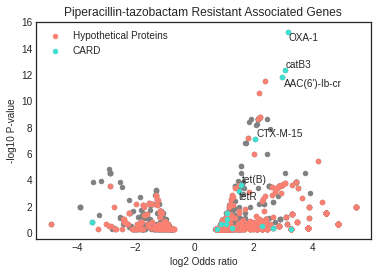

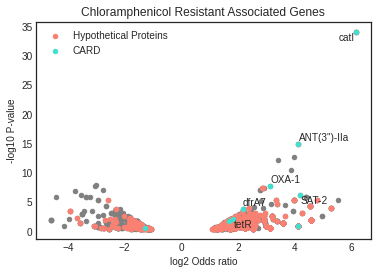

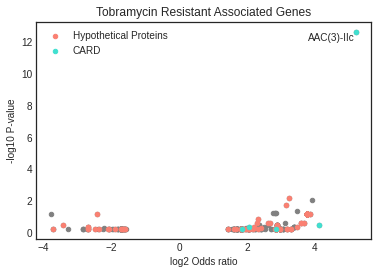

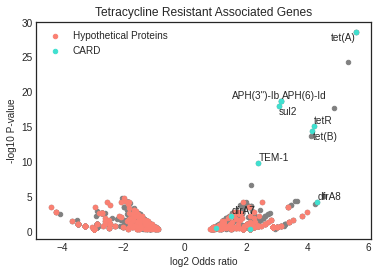

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


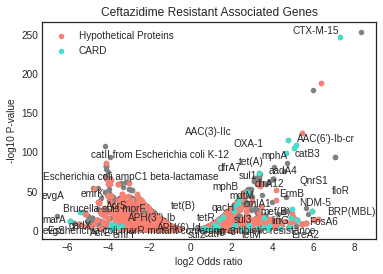

posx and posy should be finite values
posx and posy should be finite values


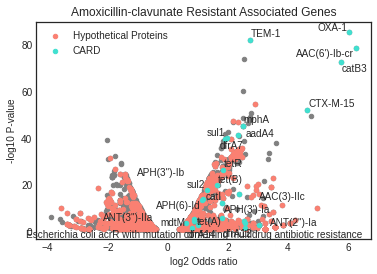

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


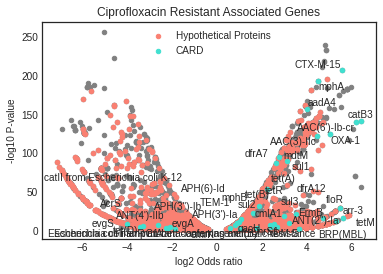

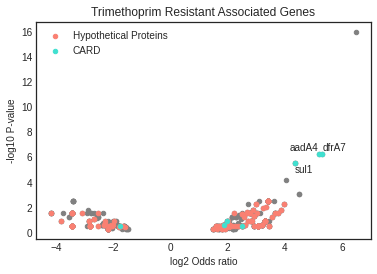

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


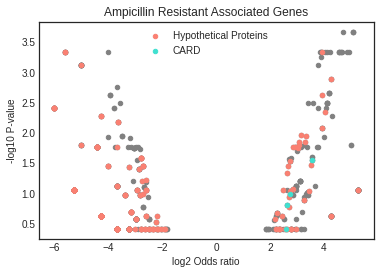

posx and posy should be finite values
posx and posy should be finite values


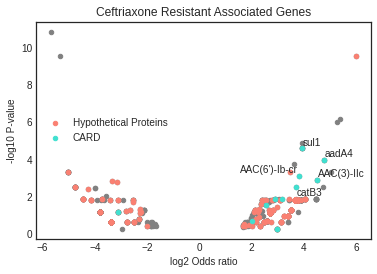

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


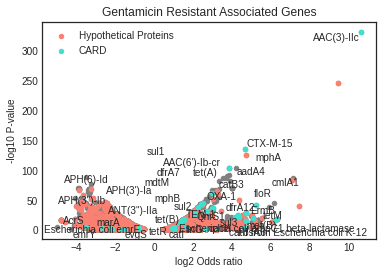

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


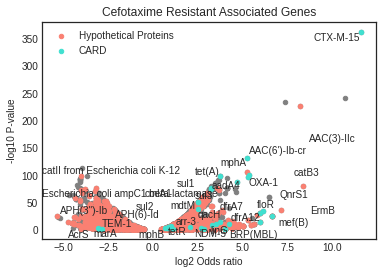

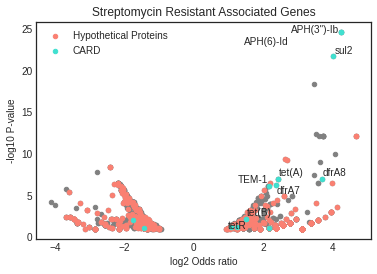

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


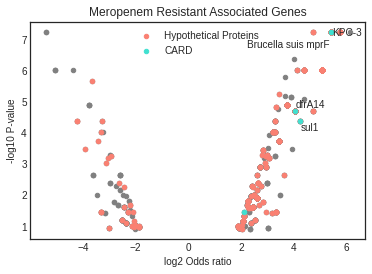

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


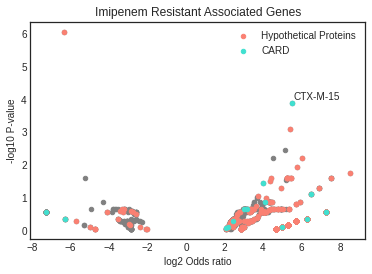

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


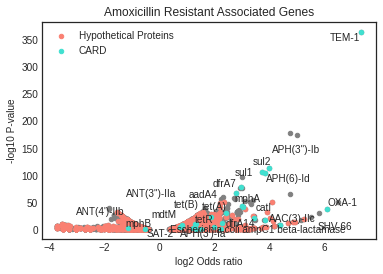

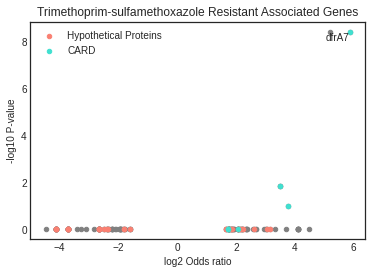

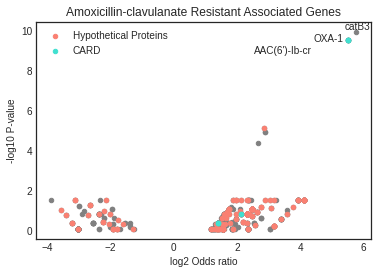

posx and posy should be finite values
posx and posy should be finite values


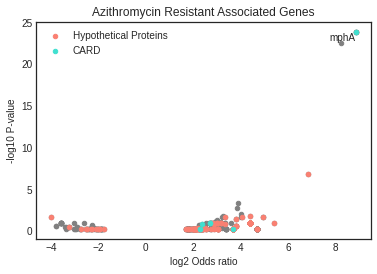

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


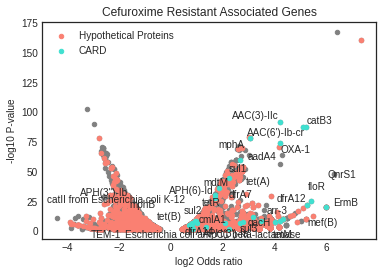

In [33]:
for abx in abx_list:
    df = read_scoary(abx)
    abx_anno = extract_anno(filter_scoary(df))
    if abx_anno.shape[0]>0:
        run_GO_enrich(abx_anno.index.tolist(), abx)
        Volcano(abx)
        abx_anno['Best_Hit_ARO'].dropna()
writer.save()